In [1]:
pip install -U imbalanced-learn

In [2]:
pip install yellowbrick

In [68]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
    average_precision_score,
    auc,
)

from imblearn.datasets import fetch_datasets

from imblearn.metrics import(
    geometric_mean_score,
    make_index_balanced_accuracy,
)

from yellowbrick.classifier import (
    ClassificationReport,
    DiscriminationThreshold,
    ROCAUC,
)

import seaborn as sns
import matplotlib.pyplot as plt


## Accuracy

In [4]:
# Load kdd
data = fetch_datasets()['protein_homo']

data = pd.concat([
    pd.DataFrame(data.data),
    pd.Series(data.target)
], axis=1)

col_names = [str(i) for i in range(74)] +['target']
data.columns = col_names

data.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,target
0,52.0,32.69,0.30,2.5,20.0,1256.8,-0.89,0.33,11.0,-55.0,...,1595.1,-1.64,2.83,-2.0,-50.0,445.2,-0.35,0.26,0.76,-1
1,58.0,33.33,0.00,16.5,9.5,608.1,0.50,0.07,20.5,-52.5,...,762.9,0.29,0.82,-3.0,-35.0,140.3,1.16,0.39,0.73,-1
2,77.0,27.27,-0.91,6.0,58.5,1623.6,-1.40,0.02,-6.5,-48.0,...,1491.8,0.32,-1.29,0.0,-34.0,658.2,-0.76,0.26,0.24,-1
3,41.0,27.91,-0.35,3.0,46.0,1921.6,-1.36,-0.47,-32.0,-51.5,...,2047.7,-0.98,1.53,0.0,-49.0,554.2,-0.83,0.39,0.73,-1
4,50.0,28.00,-1.32,-9.0,12.0,464.8,0.88,0.19,8.0,-51.5,...,479.5,0.68,-0.59,2.0,-36.0,-6.9,2.02,0.14,-0.23,-1


In [5]:
data.shape

(145751, 75)

In [6]:
# imbalanced target
data.target.value_counts() / len(data)

,count
target,
-1,0.991108
1,0.008892


In [7]:
# seperate train and test
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=42
)

X_train.shape, X_test.shape

((102025, 74), (43726, 74))

In [8]:
# Baseline: majoirty class
y_train_base = pd.Series(np.full(len(y_train), -1))
y_test_base = pd.Series(np.full(len(y_test), -1))

In [9]:
# Train model
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=2, n_jobs=4)

rf.fit(X_train, y_train)

y_train_rf = rf.predict_proba(X_train)[:,1]
y_test_rf = rf.predict_proba(X_test)[:,1]

In [10]:
lr = LogisticRegression(random_state=42, max_iter=1000)

lr.fit(X_train, y_train)

y_train_lr = lr.predict_proba(X_train)[:,1]
y_test_lr = lr.predict_proba(X_test)[:,1]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
print(f"{accuracy_score(y_test, y_test_base)=}")
print(f"{accuracy_score(y_test, rf.predict(X_test))=}")
print(f"{accuracy_score(y_test, lr.predict(X_test))=}")

accuracy_score(y_test, y_test_base)=0.9916296940035677
accuracy_score(y_test, rf.predict(X_test))=0.9961350226409916
accuracy_score(y_test, lr.predict(X_test))=0.9972098980011892


In [12]:
# minority classfied accuracy
def return_minority_perc(y_true, y_pred):
    minority_total = (y_test == 1).sum()
    minority_correct = np.sum(np.where((y_true==1)&(y_pred==1),1,0))
    return minority_correct / minority_total *100

In [13]:
print(f"{return_minority_perc(y_test, y_test_base)=}")
print(f"{return_minority_perc(y_test, rf.predict(X_test))=}")
print(f"{return_minority_perc(y_test, lr.predict(X_test))=}")

return_minority_perc(y_test, y_test_base)=0.0
return_minority_perc(y_test, rf.predict(X_test))=54.91803278688525
return_minority_perc(y_test, lr.predict(X_test))=71.03825136612022


## Precision, Recall And F-measure

### Recall
- Recall: TP / (TP + FN)
  - Recall = TP / All real positves
- Precision: TP / (TP + FP)
  - Precision = TP / All Positive predictions

### F-measure
- (2 * Precsion * Recall) / (Precision + Recall)

In [14]:
#Precision
print(f'Precision Baseline {precision_score(y_test, y_test_base)}')
print(f'Precision Randomforest {precision_score(y_test, rf.predict(X_test))}')
print(f'Precision Logistic Regression {precision_score(y_test, lr.predict(X_test))}')

Precision Baseline 0.0
Precision Randomforest 0.9804878048780488
Precision Logistic Regression 0.9420289855072463


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
#Recall
print(f'Precision Baseline {recall_score(y_test, y_test_base)}')
print(f'Precision Randomforest {recall_score(y_test, rf.predict(X_test))}')
print(f'Precision Logistic Regression {recall_score(y_test, lr.predict(X_test))}')

Precision Baseline 0.0
Precision Randomforest 0.5491803278688525
Precision Logistic Regression 0.7103825136612022


In [16]:
#F1 Score
print(f'Precision Baseline {f1_score(y_test, y_test_base, pos_label=1)}')
print(f'Precision Randomforest {f1_score(y_test, rf.predict(X_test), pos_label=1)}')
print(f'Precision Logistic Regression {f1_score(y_test, lr.predict(X_test), pos_label=1)}')

Precision Baseline 0.0
Precision Randomforest 0.7040280210157618
Precision Logistic Regression 0.8099688473520249


In [17]:
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     43360
           1       0.98      0.55      0.70       366

    accuracy                           1.00     43726
   macro avg       0.99      0.77      0.85     43726
weighted avg       1.00      1.00      1.00     43726



In [18]:
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     43360
           1       0.94      0.71      0.81       366

    accuracy                           1.00     43726
   macro avg       0.97      0.86      0.90     43726
weighted avg       1.00      1.00      1.00     43726



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


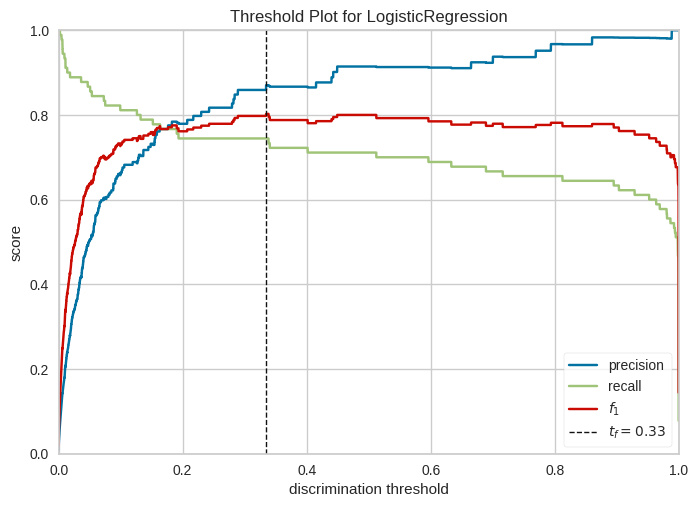

<Axes: title={'center': 'Threshold Plot for LogisticRegression'}, xlabel='discrimination threshold', ylabel='score'>

In [19]:
visualizer = DiscriminationThreshold(
    lr,
    n_trials=1,
    argmax='fscore',
    random_state=42,
    is_fitted='auto',
    exclude="queue_rate"
)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


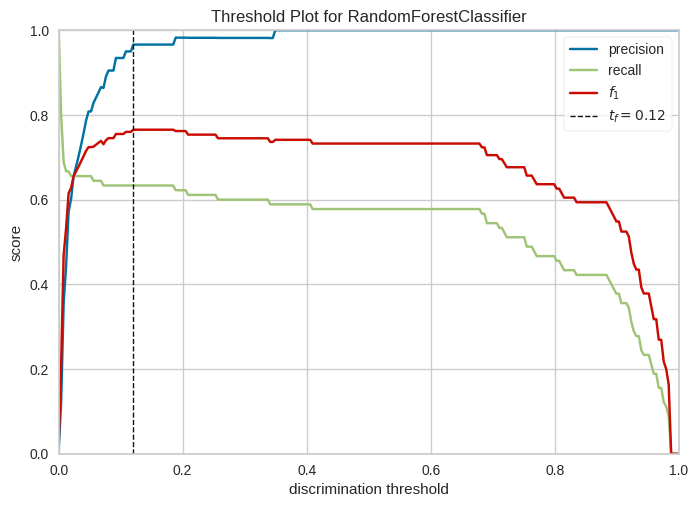

<Axes: title={'center': 'Threshold Plot for RandomForestClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [20]:
visualizer = DiscriminationThreshold(
    rf,
    n_trials=1,
    argmax='fscore',
    random_state=42,
    is_fitted='auto',
    exclude="queue_rate"
)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

## Confusion Matrix

In [24]:
confusion_matrix(y_test, y_test_base, labels=[-1, 1])

array([[43360,     0],
       [  366,     0]])

In [25]:
confusion_matrix(y_test, rf.predict(X_test), labels=[-1, 1])

array([[43356,     4],
       [  165,   201]])

In [26]:
confusion_matrix(y_test, lr.predict(X_test), labels=[-1, 1])

array([[43344,    16],
       [  106,   260]])

In [28]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_base, labels=[-1, 1]).ravel()

FPR = fp / (tn + fp)
FNR = fn / (tp + fn)

print(f"{FPR=}")
print(f"{FNR=}")

FPR=0.0
FNR=1.0


In [29]:
tn, fp, fn, tp = confusion_matrix(y_test, rf.predict(X_test), labels=[-1, 1]).ravel()

FPR = fp / (tn + fp)
FNR = fn / (tp + fn)

print(f"{FPR=}")
print(f"{FNR=}")

FPR=9.225092250922509e-05
FNR=0.45081967213114754


In [30]:
tn, fp, fn, tp = confusion_matrix(y_test, lr.predict(X_test), labels=[-1, 1]).ravel()

FPR = fp / (tn + fp)
FNR = fn / (tp + fn)

print(f"{FPR=}")
print(f"{FNR=}")

FPR=0.00036900369003690036
FNR=0.2896174863387978


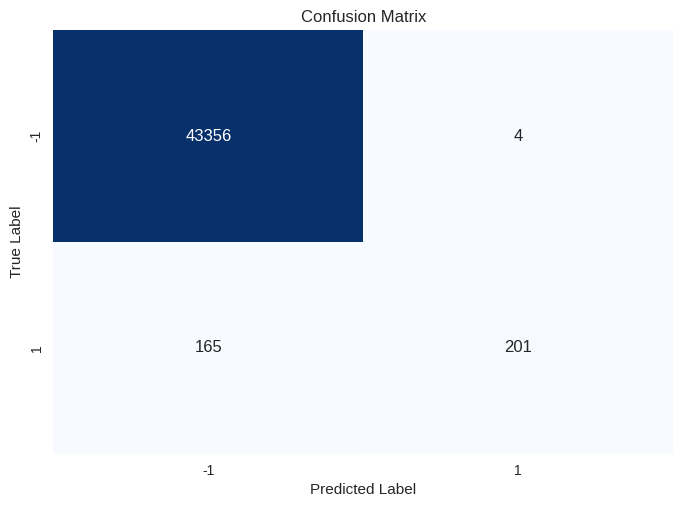

In [36]:
cm = confusion_matrix(y_test, rf.predict(X_test), labels=[-1, 1])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['-1', '1'], yticklabels=['-1', '1'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

## Balanced Accuracy

- Balanced Accuracy = (Recall_0 + Recall_1) / 2

In [39]:
print(f"{balanced_accuracy_score(y_test, y_test_base)=}")
print(f"{balanced_accuracy_score(y_test, rf.predict(X_test))=}")
print(f"{balanced_accuracy_score(y_test, lr.predict(X_test))=}")

balanced_accuracy_score(y_test, y_test_base)=0.5
balanced_accuracy_score(y_test, rf.predict(X_test))=0.7745440384731717
balanced_accuracy_score(y_test, lr.predict(X_test))=0.8550067549855827


## Geometric mean(幾何平均)
- 各クラスの精度を最大化する時に利用
- sqrt(Recall(TPR) * TNR) -> sqrt(sensitivity * specifity)

## Dominace
- range -1 to 1
  - 1 -> minority positve class の識別が完璧
  - -1は最悪
- Recall(TPR) - TNR

## Index of imbalanced accuracy(IBA)
- IBA = (1 + alpha * Dominance) * M

In [41]:
# recall
print(f"{recall_score(y_test, y_test_base)=}")
print(f"{recall_score(y_test, rf.predict(X_test))=}")
print(f"{recall_score(y_test, lr.predict(X_test))=}")

recall_score(y_test, y_test_base)=0.0
recall_score(y_test, rf.predict(X_test))=0.5491803278688525
recall_score(y_test, lr.predict(X_test))=0.7103825136612022


In [42]:
# TNR
print(f"{recall_score(y_test, y_test_base, pos_label=-1)=}")
print(f"{recall_score(y_test, rf.predict(X_test), pos_label=-1)=}")
print(f"{recall_score(y_test, lr.predict(X_test), pos_label=-1)=}")

recall_score(y_test, y_test_base, pos_label=-1)=1.0
recall_score(y_test, rf.predict(X_test), pos_label=-1)=0.9999077490774908
recall_score(y_test, lr.predict(X_test), pos_label=-1)=0.9996309963099631


In [43]:
# Geometric mean
print(f"{geometric_mean_score(y_test, y_test_base)=}")
print(f"{geometric_mean_score(y_test, rf.predict(X_test))=}")
print(f"{geometric_mean_score(y_test, lr.predict(X_test))=}")

geometric_mean_score(y_test, y_test_base)=0.0
geometric_mean_score(y_test, rf.predict(X_test))=0.7410328369761915
geometric_mean_score(y_test, lr.predict(X_test))=0.8426864066141826


In [45]:
# Dominance
def dominance(y_true, y_pred):
  tpr = recall_score(y_true, y_pred)
  tnr = recall_score(y_true, y_pred, pos_label=-1)
  return tpr - tnr

print(f"{dominance(y_test, y_test_base)=}")
print(f"{dominance(y_test, rf.predict(X_test))=}")
print(f"{dominance(y_test, lr.predict(X_test))=}")

dominance(y_test, y_test_base)=-1.0
dominance(y_test, rf.predict(X_test))=-0.4507274212086383
dominance(y_test, lr.predict(X_test))=-0.2892484826487609


In [46]:
iba = make_index_balanced_accuracy(alpha=0.5, squared=True) (geometric_mean_score)

print(f"{iba(y_test, y_test_base)=}")
print(f"{iba(y_test, rf.predict(X_test))=}")
print(f"{iba(y_test, lr.predict(X_test))=}")

iba(y_test, y_test_base)=0.0
iba(y_test, rf.predict(X_test))=0.5491296654769828
iba(y_test, lr.predict(X_test))=0.7101203798923235


In [47]:
iba_accuracy = make_index_balanced_accuracy(alpha=0.5, squared=True) (accuracy_score)

print(f"{iba_accuracy(y_test, y_test_base)=}")
print(f"{iba_accuracy(y_test, rf.predict(X_test))=}")
print(f"{iba_accuracy(y_test, lr.predict(X_test))=}")

iba_accuracy(y_test, y_test_base)=0.4916647250148047
iba_accuracy(y_test, rf.predict(X_test))=0.7686599575113314
iba_accuracy(y_test, lr.predict(X_test))=0.8506092462648812


## ROC Curve
- Y: TP Rate, X: FP RateでPlotした曲線
- AUC -> ROCの下側の面接
  - 完璧なモデルはAUC=1(左上に張り付く）
  - Random modelはAUC=0.5
- 異なるモデルのROC Curveを書いた場合に、その曲線が交差する場合は比較できない


In [51]:
# ROC-AUC
print(f"{roc_auc_score(y_test, y_test_base)=}")
print(f"{roc_auc_score(y_test, rf.predict(X_test))=}")
print(f"{roc_auc_score(y_test, lr.predict(X_test))=}")

roc_auc_score(y_test, y_test_base)=0.5
roc_auc_score(y_test, rf.predict(X_test))=0.7745440384731717
roc_auc_score(y_test, lr.predict(X_test))=0.8550067549855825


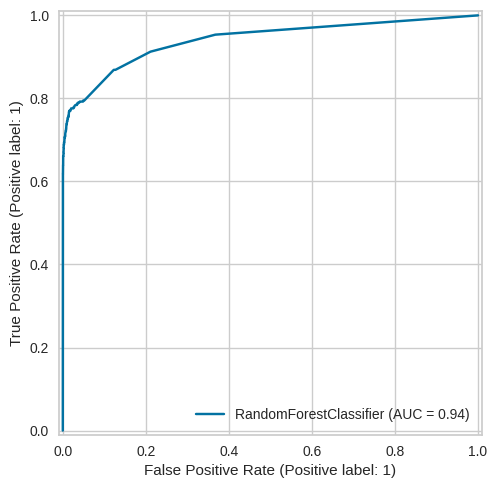

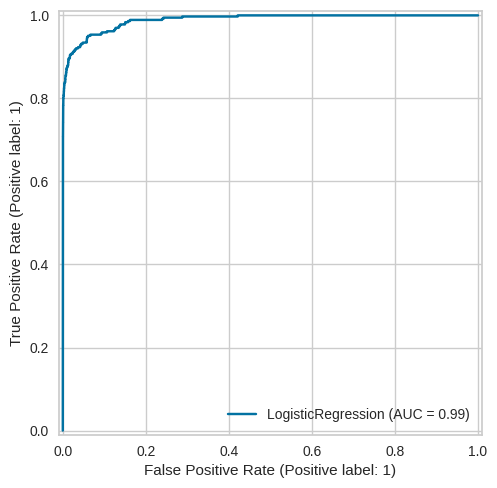

In [57]:
rf_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test)
logit_disp = RocCurveDisplay.from_estimator(lr, X_test, y_test)

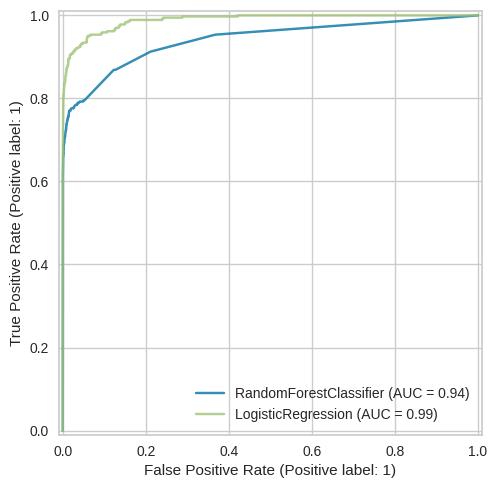

In [58]:
ax = plt.gca()
rf_disp.plot(ax=ax, alpha=0.8)
logit_disp.plot(ax=ax, alpha=0.8)

## Precsion Recall Curve

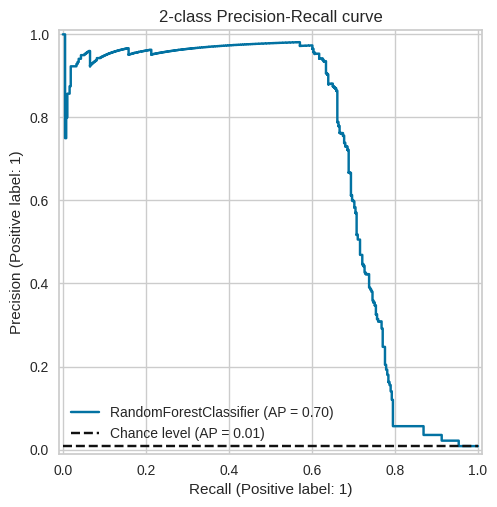

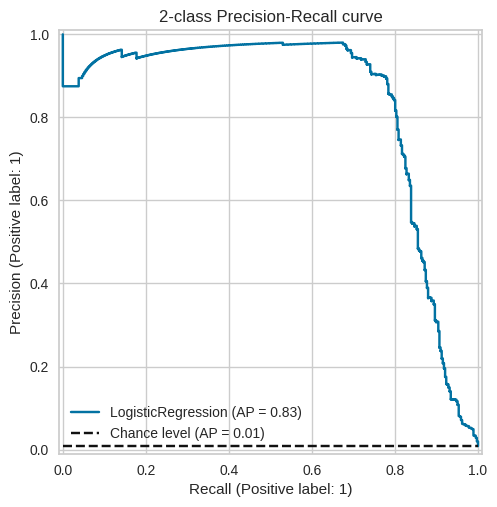

In [70]:
rf_disp = PrecisionRecallDisplay.from_estimator(rf, X_test, y_test, plot_chance_level=True)
_ = rf_disp.ax_.set_title("2-class Precision-Recall curve")

lr_disp = PrecisionRecallDisplay.from_estimator(lr, X_test, y_test, plot_chance_level=True)
_ = lr_disp.ax_.set_title("2-class Precision-Recall curve")

In [71]:
precision, recall ,threshold = precision_recall_curve(y_test, rf.predict(X_test))

auc_logit = auc(recall, precision)
print(f"{auc_logit}")

0.7667208156759251
